# IMPORTS AND READ CSV

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import normal_ad
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from scipy.signal import periodogram
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)
df_time_series.index = df_time_series.asfreq('MS').index
df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

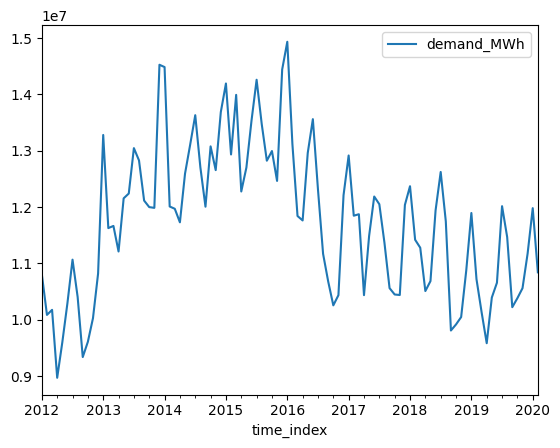

In [3]:
df_time_series.plot()

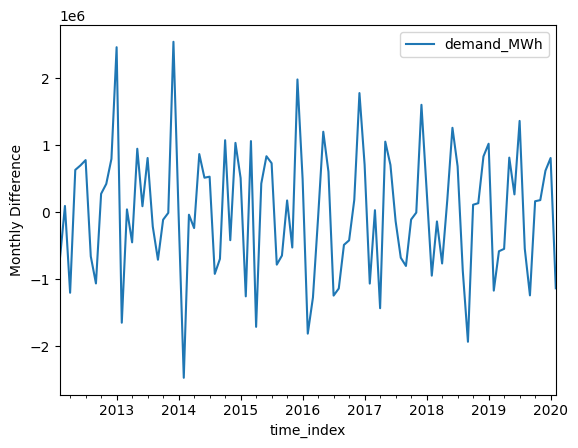

In [4]:
# Need to difference
df_time_series_diff_first = df_time_series.diff().dropna()
ax = df_time_series_diff_first.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [5]:
utils.is_stationary(df_time_series_diff_first)

False

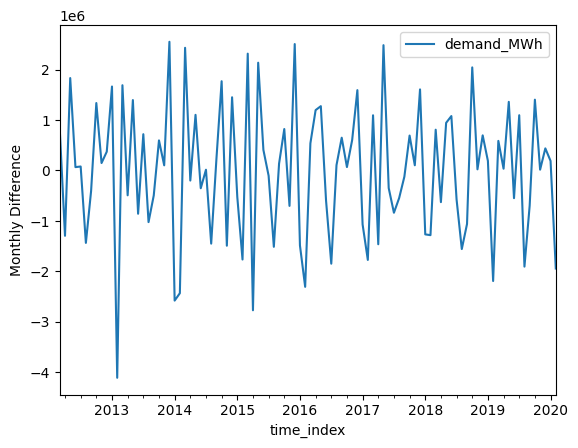

In [6]:
# Differenciate again
df_time_series_diff_second = df_time_series_diff_first.diff().dropna()
ax = df_time_series_diff_second.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [7]:
utils.is_stationary(df_time_series_diff_second)

True

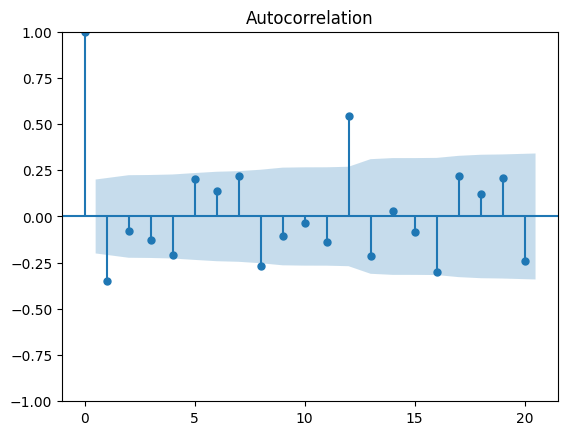

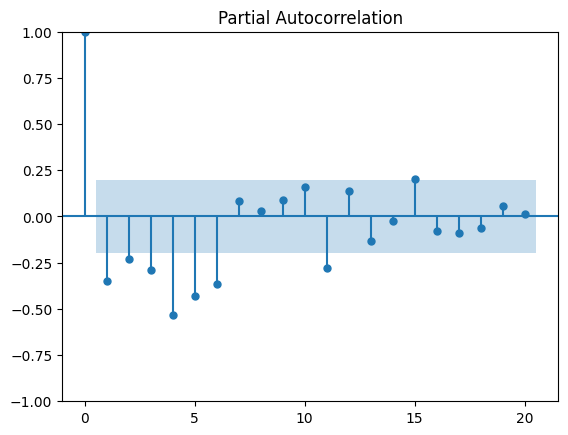

In [8]:
plot_acf(df_time_series_diff_second, lags=20)
plot_pacf(df_time_series_diff_second, lags=20, method="ywm")
plt.show()

r2_score: 0.6999744060057267
mean_absolute_error: 568504.1292410605
mean_absolute_percentage_error: 0.048162420374084115
mean_squared_error: 530313399871.8954
root_mean_squared_error: 728226.2010336454


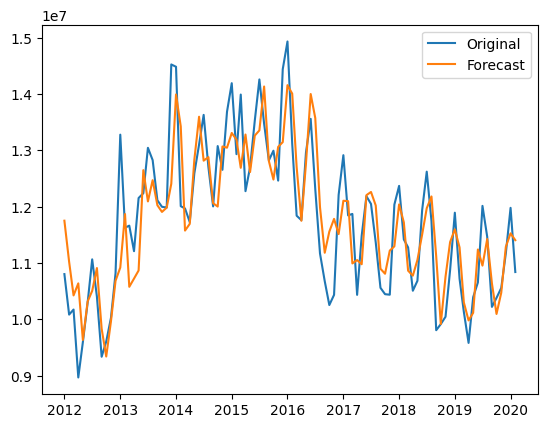

In [9]:
# Forecast the first ARMA(1,1) model
mod = ARIMA(df_time_series, order=(5,0,1))
res = mod.fit()
orig_data = df_time_series
pred = res.predict()
print(f'r2_score: {r2_score(orig_data, pred)}')
print(f'mean_absolute_error: {mean_absolute_error(orig_data, pred)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(orig_data, pred)}')
print(f'mean_squared_error: {mean_squared_error(orig_data, pred)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(orig_data, pred))}')
plt.plot(orig_data, label='Original')
plt.plot(pred, label='Forecast')
plt.legend()
plt.show()

# RESIDUALS

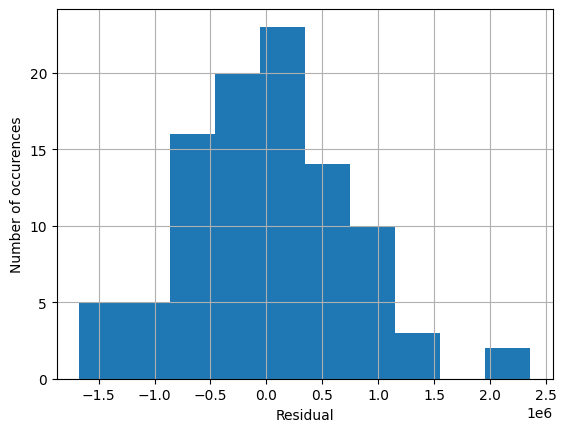

In [10]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Residual')
plt.show()

In [11]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             demand_MWh   No. Observations:                   98
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1461.492
Date:                Fri, 18 Nov 2022   AIC                           2938.984
Time:                        11:49:02   BIC                           2959.664
Sample:                    01-01-2012   HQIC                          2947.349
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.175e+07   1.41e-08   8.33e+14      0.000    1.18e+07    1.18e+07
ar.L1          0.7675      0.206      3.732      0.000       0.364       1.171
ar.L2         -0.1774      0.187     -0.947      0.343      -0.544       0.190
ar.L3         -0.0669      0.140     -0.478      0.632      -0.341       0.207
ar.L4         -0.0149      0.133     -0.112      0.911      -0.276       0.246
ar.L5          0.4325      0.136      3.188      0.001       0.167       0.698
ma.L1         -0.1368      0.241     -0.568      0.570      -0.608       0.335
sigma2      5.159e+11   6.21e-13   8.31e+23      0.000    5.16e+11    5.16e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.40   Skew:                             0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+39. Standard errors may be unstable.
"""

# PMDARIMA

In [12]:
df_time_series[['demand_MWh']].tail(12)

,demand_MWh
time_index,
2019-03-01,1.013390e+07
2019-04-01,9.582935e+06
2019-05-01,1.039433e+07
2019-06-01,1.065671e+07
2019-07-01,1.201620e+07
2019-08-01,1.146801e+07
2019-09-01,1.022258e+07
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07


In [13]:
df_time_series[['demand_MWh']]

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07
2019-12-01,1.117532e+07


In [14]:
train, test = train_test_split(df_time_series[['demand_MWh']], train_size=df_time_series[['demand_MWh']].size-12)

In [15]:
# Fit your model
model = pm.auto_arima(train, seasonal=True, m=2, n_jobs=-1, stepwise=False)

In [16]:
test.shape[0]

12

In [17]:
forecasts_test_pmarima = model.predict(test.shape[0])  # predict N steps into the future

r2_score: 0.7236281015251186
mean_absolute_error: 289851.6446221758
mean_absolute_percentage_error: 0.02706333731311363
mean_squared_error: 141314966301.10577
root_mean_squared_error: 375918.82940484077


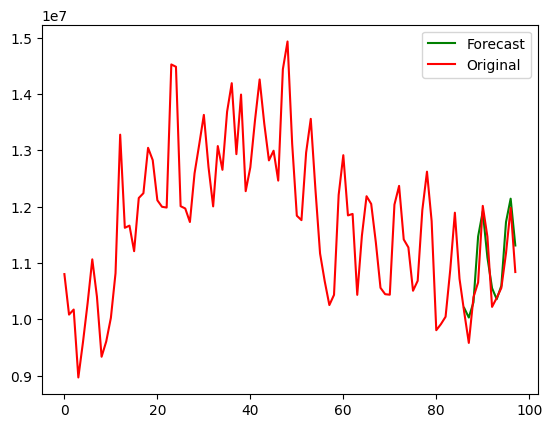

In [18]:
# Visualize the forecasts (blue=train, green=forecasts)
print(f'r2_score: {r2_score(test, forecasts_test_pmarima)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_test_pmarima)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_test_pmarima)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_test_pmarima)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_test_pmarima))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_test_pmarima, c='green', label= 'Forecast')
plt.plot(x, df_time_series[['demand_MWh']], c='red', label= 'Original')
plt.legend()
plt.show()

r2_score: 0.7236281015251186


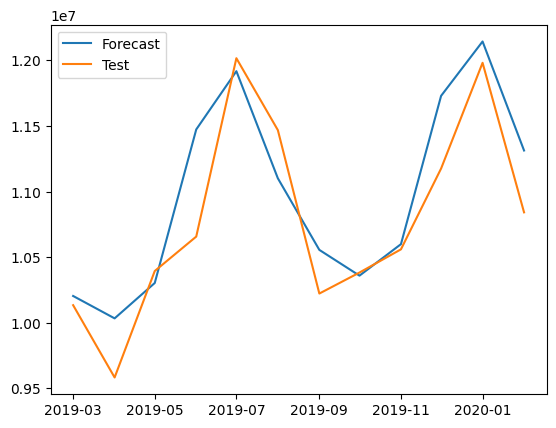

In [19]:

print(f'r2_score: {r2_score(test, forecasts_test_pmarima)}')
plt.plot(forecasts_test_pmarima, label='Forecast')
plt.plot(test, label='Test')
plt.legend()
plt.show()

In [20]:
model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 2),
      suppress_warnings=True)

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   86
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 2)   Log Likelihood               -1287.289
Date:                                Fri, 18 Nov 2022   AIC                           2588.577
Time:                                        11:49:17   BIC                           2605.758
Sample:                                    01-01-2012   HQIC                          2595.491
                                         - 02-01-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.148e+06   4.01e-10   7.84e+15      0.000    3.15e+06    3.15e+06
ar.L1          0.9083      0.010     90.159      0.000       0.889       0.928
ar.S.L2       -0.9981      0.074    -13.526      0.000      -1.143      -0.853
ar.S.L4       -0.9926      0.051    -19.528      0.000      -1.092      -0.893
ma.S.L2        0.9735      0.244      3.995      0.000       0.496       1.451
ma.S.L4        0.9096      0.340      2.673      0.008       0.243       1.577
sigma2       8.28e+11   3.41e-13   2.43e+24      0.000    8.28e+11    8.28e+11
===================================================================================
Ljung-Box (L1) (Q):                   7.11   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.01   Prob(JB):                         0.12
Heteroskedasticity (H):               0.38   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+41. Standard errors may be unstable.
"""

# PMDARIMA; W/ BUSINESS DAYS AS EXOGENOUS VARIABLES

In [23]:
train_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in train.index]
test_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in test.index]

In [24]:
np.array(train_exog).size

86

In [25]:
train

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2018-10-01,9.916300e+06
2018-11-01,1.004732e+07
2018-12-01,1.087618e+07


In [26]:
train_exog_reshaped = np.array(train_exog).reshape(-1,1)
train_exog_reshaped.shape

(86, 1)

In [30]:
model = pm.auto_arima(train, X=train_exog_reshaped, seasonal=True, m=2, n_jobs=-1, stepwise=False)

In [31]:
forecasts_test_pmarima = model.predict(test.shape[0], X=np.array(test_exog).reshape(-1,1))  # predict N steps into the future

r2_score: 0.5958836383599084
mean_absolute_error: 388119.3578275389
mean_absolute_percentage_error: 0.03626166818745192
mean_squared_error: 206633490387.53796
root_mean_squared_error: 454569.5660595174


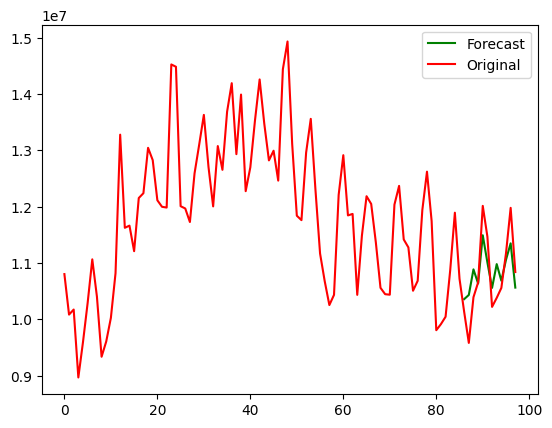

In [32]:
# Visualize the forecasts (blue=train, green=forecasts)
print(f'r2_score: {r2_score(test, forecasts_test_pmarima)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_test_pmarima)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_test_pmarima)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_test_pmarima)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_test_pmarima))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_test_pmarima, c='green', label= 'Forecast')
plt.plot(x, df_time_series[['demand_MWh']], c='red', label= 'Original')
plt.legend()
plt.show()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   86
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 2)   Log Likelihood               -1273.674
Date:                           Fri, 18 Nov 2022   AIC                           2559.348
Time:                                   11:49:23   BIC                           2573.933
Sample:                               01-01-2012   HQIC                          2565.211
                                    - 02-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.007e+04   2.34e+05      0.086      0.932   -4.39e+05     4.8e+05
x1          2.197e+05   9.54e+04      2.303      0.021    3.27e+04    4.07e+05
ar.L1          0.6200      0.170      3.651      0.000       0.287       0.953
ar.S.L2       -0.8317      0.192     -4.341      0.000      -1.207      -0.456
ar.S.L4       -0.5595      0.192     -2.910      0.004      -0.936      -0.183
sigma2      1.514e+12      0.010   1.56e+14      0.000    1.51e+12    1.51e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.77   Prob(JB):                         0.67
Heteroskedasticity (H):               0.53   Skew:                             0.24
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+30. Standard errors may be unstable.
"""

# STATSMODEL SARIMA

In [34]:
train = df_time_series['demand_MWh'][:-12]
test = df_time_series['demand_MWh'][-12:]

In [35]:
mod = SARIMAX(train, order=(1,2,1), 
seasonal_order=(1,2,1,6))
res = mod.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12)

-11.319069319127054


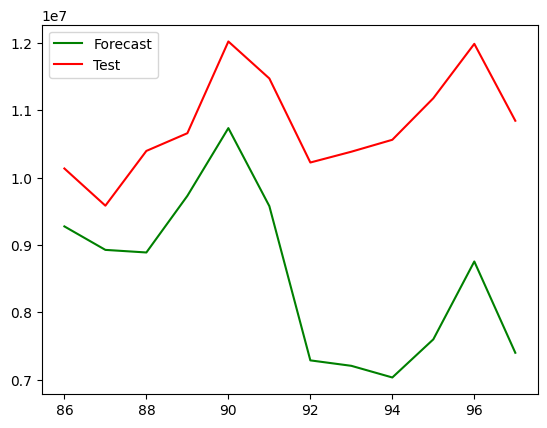

In [36]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))

x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()


# GRID SEARCH WITH SEASONALITY 6

In [37]:
scores = []
for p in range(2):
    for i in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            mod = SARIMAX(train, order=(p, i,q), seasonal_order=(P,D,Q,6))
                            res = mod.fit(disp=False)
                            score = [p,i,q,P,D,Q,r2_score(test, res.forecast(steps=12))]
                            print(score)
                            scores.append(score)
                            del mod
                            del res
                        except:
                            print('errored')
res = pd.DataFrame(scores)
res.columns = ['p', 'i', 'q', 'P', 'D', 'Q', 'score']
res.sort_values('score')

[0, 0, 0, 0, 0, 0, -227.46279693036848]
[0, 0, 0, 0, 0, 1, -156.70736523950904]
[0, 0, 0, 0, 1, 0, 0.7194222268340598]
[0, 0, 0, 0, 1, 1, 0.7235764703166702]
[0, 0, 0, 1, 0, 0, 0.6249191884604306]
[0, 0, 0, 1, 0, 1, 0.7819949041565684]
[0, 0, 0, 1, 1, 0, 0.725075501471498]
[0, 0, 0, 1, 1, 1, 0.5980279261312251]
[0, 0, 1, 0, 0, 0, -215.67163926355414]
[0, 0, 1, 0, 0, 1, -152.8424871722635]
[0, 0, 1, 0, 1, 0, 0.6626689410590202]
[0, 0, 1, 0, 1, 1, 0.7105781532959661]
[0, 0, 1, 1, 0, 0, -38.825712626643735]
[0, 0, 1, 1, 0, 1, -23.15362452208649]
[0, 0, 1, 1, 1, 0, 0.7307033567179828]
[0, 0, 1, 1, 1, 1, 0.6144561672141298]
[0, 1, 0, 0, 0, 0, -0.007984948244809997]
[0, 1, 0, 0, 0, 1, 0.02882338637009718]
[0, 1, 0, 0, 1, 0, -6.027489454574323]
[0, 1, 0, 0, 1, 1, -0.667385085043418]
[0, 1, 0, 1, 0, 0, 0.02825856076786748]
[0, 1, 0, 1, 0, 1, 0.6145947511776593]
[0, 1, 0, 1, 1, 0, -1.7522958840219198]
[0, 1, 0, 1, 1, 1, -0.7811715675541695]
[0, 1, 1, 0, 0, 0, -4.04818927381978e-05]
[0, 1, 1, 0,

,p,i,q,P,D,Q,score
0,0,0,0,0,0,0,-227.462797
8,0,0,1,0,0,0,-215.671639
1,0,0,0,0,0,1,-156.707365
9,0,0,1,0,0,1,-152.842487
12,0,0,1,1,0,0,-38.825713
...,...,...,...,...,...,...,...
6,0,0,0,1,1,0,0.725076
14,0,0,1,1,1,0,0.730703
39,1,0,0,1,1,1,0.747754
38,1,0,0,1,1,0,0.775768


In [38]:
mod = SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,1,6))
res = mod.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12)

0.7819949041565684
r2_score: 0.7819949041565684
mean_absolute_error: 281594.8362929619
mean_absolute_percentage_error: 0.026557639796868756
mean_squared_error: 111470749893.85674
root_mean_squared_error: 333872.35568980064


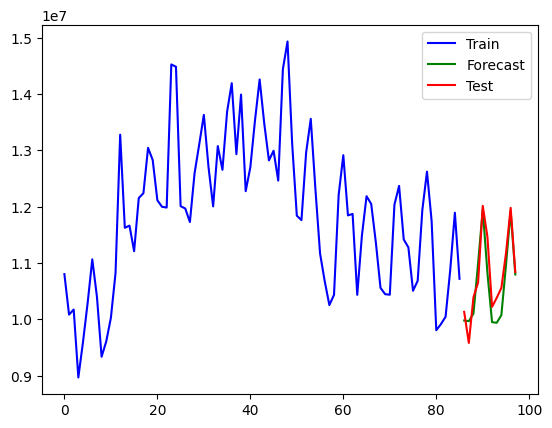

In [39]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

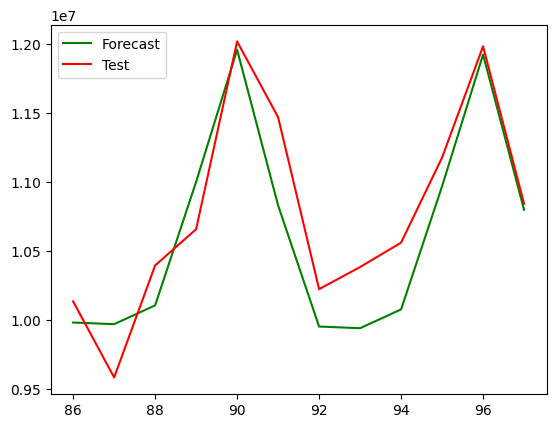

In [40]:
x = np.arange(df_time_series[['demand_MWh']].size)
# plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

# SARIMAX; BUSINESS DAYS AS EXOGENOUS VARIABLES

## WITHOUT GRID SEARCH

In [41]:
train_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in train.index]
test_exog = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in test.index]

In [42]:
train1 = pd.DataFrame(train)

In [43]:
train1

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2018-10-01,9.916300e+06
2018-11-01,1.004732e+07
2018-12-01,1.087618e+07


In [44]:
train2 = train1.copy()

In [45]:
train2['business_days'] = train_exog

In [46]:
train2.corr()

,demand_MWh,business_days
demand_MWh,1.000000,0.163115
business_days,0.163115,1.000000


In [47]:
sarimax_model = SARIMAX(endog= train, exog= train_exog, order=(0,0,0), seasonal_order=(1,0,1,6))
res = sarimax_model.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12, exog=test_exog)

0.4581688706007896
r2_score: 0.4581688706007896
mean_absolute_error: 440685.8843492346
mean_absolute_percentage_error: 0.04193246382144719
mean_squared_error: 277050048194.0229
root_mean_squared_error: 526355.439027681


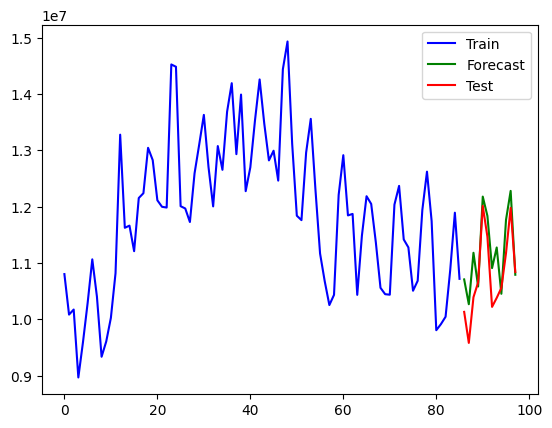

In [48]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

## WITH GRIDSEARCH

In [49]:
scores = []
for p in range(2):
    for i in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            mod = SARIMAX(endog= train, exog= train_exog, order=(p,i,q), seasonal_order=(P,D,Q,6))
                            res = mod.fit(disp=False)
                            score = [p,i,q,P,D,Q,r2_score(test, res.forecast(steps=12, exog=test_exog))]
                            print(score)
                            scores.append(score)
                            del mod
                            del res
                        except:
                            print('errored')
res = pd.DataFrame(scores)
res.columns = ['p', 'i', 'q', 'P', 'D', 'Q', 'score']
res.sort_values('score')

[0, 0, 0, 0, 0, 0, -2.479140492503917]
[0, 0, 0, 0, 0, 1, -1.2610800983518242]
[0, 0, 0, 0, 1, 0, 0.8328773999519903]
[0, 0, 0, 0, 1, 1, 0.8398852889631782]
[0, 0, 0, 1, 0, 0, 0.39753190079647516]
[0, 0, 0, 1, 0, 1, 0.4581688706007896]
[0, 0, 0, 1, 1, 0, 0.8432817034912232]
[0, 0, 0, 1, 1, 1, 0.6770173970711952]
[0, 0, 1, 0, 0, 0, -2.522971052264179]
[0, 0, 1, 0, 0, 1, -1.7067269631859547]
[0, 0, 1, 0, 1, 0, 0.8154912292680243]
[0, 0, 1, 0, 1, 1, 0.8621092068081789]
[0, 0, 1, 1, 0, 0, -0.3981225286118564]
[0, 0, 1, 1, 0, 1, -0.12018514061316288]
[0, 0, 1, 1, 1, 0, 0.8667550234263806]
[0, 0, 1, 1, 1, 1, 0.8193554709159503]
[0, 1, 0, 0, 0, 0, -0.12654544948205482]
[0, 1, 0, 0, 0, 1, 0.18320821320537506]
[0, 1, 0, 0, 1, 0, 0.023646824190393656]
[0, 1, 0, 0, 1, 1, 0.7812770380571643]
[0, 1, 0, 1, 0, 0, 0.5148624606332104]
[0, 1, 0, 1, 0, 1, 0.7591107549467799]
[0, 1, 0, 1, 1, 0, 0.15259166709641314]
[0, 1, 0, 1, 1, 1, 0.7159858337957483]
[0, 1, 1, 0, 0, 0, -0.04058694371202809]
[0, 1, 1, 0

,p,i,q,P,D,Q,score
8,0,0,1,0,0,0,-2.522971
0,0,0,0,0,0,0,-2.479140
40,1,0,1,0,0,0,-2.364412
32,1,0,0,0,0,0,-2.251010
9,0,0,1,0,0,1,-1.706727
...,...,...,...,...,...,...,...
3,0,0,0,0,1,1,0.839885
6,0,0,0,1,1,0,0.843282
11,0,0,1,0,1,1,0.862109
35,1,0,0,0,1,1,0.865327


In [50]:
sarimax_model = SARIMAX(endog= train, exog= train_exog, order=(0,0,1), seasonal_order=(1,1,0,6))
res = sarimax_model.fit(disp=False)
forecasts_sarimax = res.forecast(steps=12, exog=test_exog)

0.8667550234263806
r2_score: 0.8667550234263806
mean_absolute_error: 201281.18769217143
mean_absolute_percentage_error: 0.01913732584779668
mean_squared_error: 68131056298.41744
root_mean_squared_error: 261019.26422855735


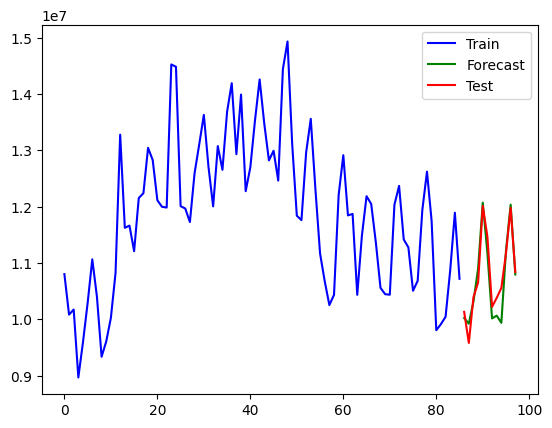

In [51]:
# Visualize the forecasts
print(r2_score(test, forecasts_sarimax))
print(f'r2_score: {r2_score(test, forecasts_sarimax)}')
print(f'mean_absolute_error: {mean_absolute_error(test, forecasts_sarimax)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(test, forecasts_sarimax)}')
print(f'mean_squared_error: {mean_squared_error(test, forecasts_sarimax)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(test, forecasts_sarimax))}')
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

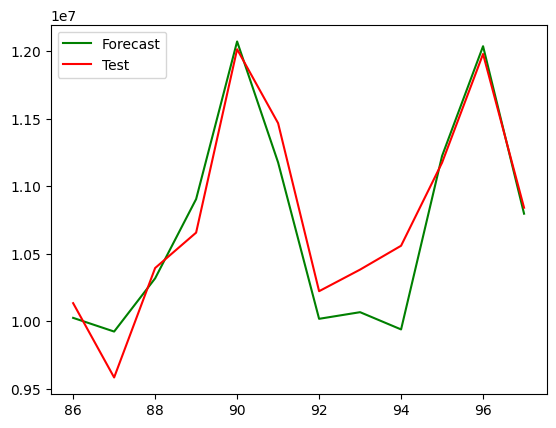

In [52]:
x = np.arange(df_time_series[['demand_MWh']].size)
# plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.legend()
plt.show()

# PREDICTION INTERVALS

In [53]:
forecasts_sarimax

2019-03-01    1.002489e+07
2019-04-01    9.923384e+06
2019-05-01    1.031785e+07
2019-06-01    1.090532e+07
2019-07-01    1.207382e+07
2019-08-01    1.117694e+07
2019-09-01    1.001782e+07
2019-10-01    1.006700e+07
2019-11-01    9.939136e+06
2019-12-01    1.122510e+07
2020-01-01    1.203866e+07
2020-02-01    1.079720e+07
Freq: MS, Name: predicted_mean, dtype: float64

In [54]:
test

time_index
2019-03-01    1.013390e+07
2019-04-01    9.582935e+06
2019-05-01    1.039433e+07
2019-06-01    1.065671e+07
2019-07-01    1.201620e+07
2019-08-01    1.146801e+07
2019-09-01    1.022258e+07
2019-10-01    1.038260e+07
2019-11-01    1.055948e+07
2019-12-01    1.117532e+07
2020-01-01    1.198120e+07
2020-02-01    1.084142e+07
Freq: MS, Name: demand_MWh, dtype: float64

In [55]:
residuals = test - forecasts_sarimax
residuals

time_index
2019-03-01    109008.930193
2019-04-01   -340448.241767
2019-05-01     76479.223530
2019-06-01   -248604.667806
2019-07-01    -57617.833305
2019-08-01    291067.615612
2019-09-01    204754.821093
2019-10-01    315603.763918
2019-11-01    620344.664145
2019-12-01    -49773.296724
2020-01-01    -57451.015119
2020-02-01     44220.179094
Freq: MS, dtype: float64

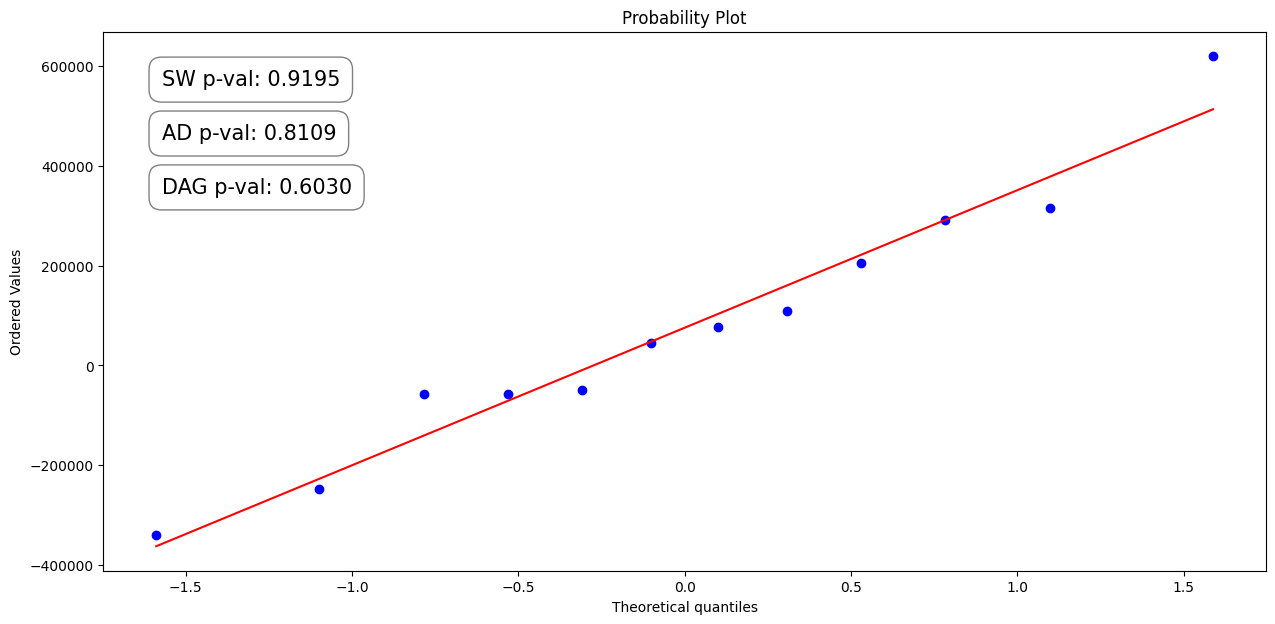

In [56]:
sw_result = stats.shapiro(residuals) # Anderson-Darling
ad_result = normal_ad(np.array(residuals), axis=0) # Kolmogorov-Smirnov
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate') # D’Agostino K-squared

plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

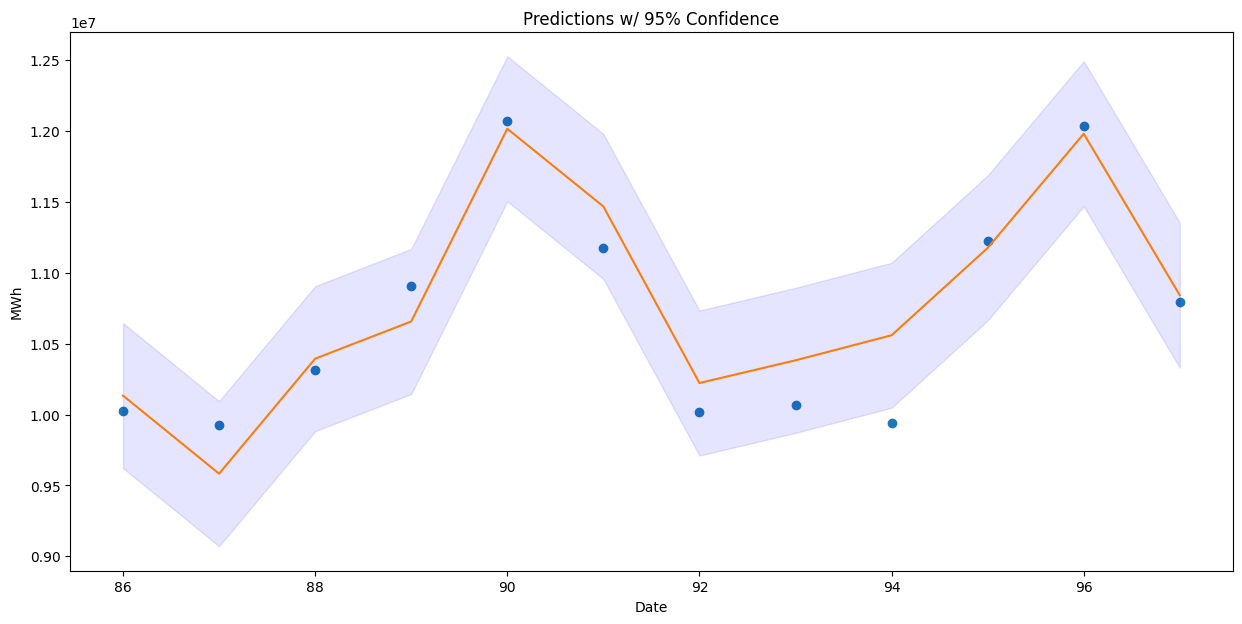

In [57]:
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x[(df_time_series[['demand_MWh']].size-12):], test, color='#fc7d0b', label='Valid')
ax.scatter(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax)
ax.fill_between(x[(df_time_series[['demand_MWh']].size-12):], (test-band_size), (test+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('MWh')
plt.show()

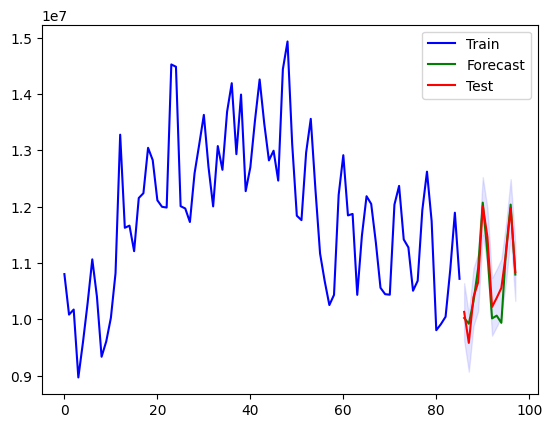

In [58]:
x = np.arange(df_time_series[['demand_MWh']].size)
plt.plot(x[:(df_time_series[['demand_MWh']].size-12)], train, c='blue', label='Train')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], forecasts_sarimax, c='green', label='Forecast')
plt.plot(x[(df_time_series[['demand_MWh']].size-12):], test, c='red', label='Test')
plt.fill_between(x[(df_time_series[['demand_MWh']].size-12):], (test-band_size), (test+band_size), color='b', alpha=.1)
plt.legend()
plt.show()